# Library

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Filtering Function

In [37]:
def data_filtering(df, filter_zero=True, filter_expression=True, filter_group_size=True):
    if filter_zero:
        zero_counts = (df == 0).mean()
        selected_features = zero_counts[zero_counts < 0.99].index
        df = df[selected_features]
    
    return df

# Plotting Function

### Hierarchical Cluster Map

In [38]:
def cluster_map(df, top_n, title='Hierarchical Clustering Heatmap of mRNA Expression', figsize=(12, 10), savedir="miDGD/plots", filename=None):
    # Extract the expression data (excluding the last four columns)
    expression_data = df.iloc[:, :-4]
    
    variances = expression_data.var(axis=0)
    top_gene = variances.nlargest(top_n).index
    expression_data = expression_data[top_gene]
    
    # Standardize the expression data
    scaler = StandardScaler()
    expression_data_scaled = scaler.fit_transform(expression_data)
    
    # Convert the scaled expression data back to a DataFrame
    expression_data = pd.DataFrame(expression_data_scaled, columns=expression_data.columns)
    
    # Add the cancer type information to the scaled expression DataFrame
    expression_data['cancer_type'] = df['cancer_type'].values
    expression_data['color'] = df['color'].values
    
    color_dict = dict(zip(expression_data['cancer_type'].unique(), expression_data['color'].unique()))
    row_colors = expression_data['cancer_type'].map(color_dict)
    
    # Create a clustermap using Seaborn
    plt.figure(figsize=figsize)
    sns.clustermap(expression_data.iloc[:, :-2], 
                       method='ward', 
                       metric='euclidean',
                       row_colors=row_colors, 
                       cmap='coolwarm', 
                       z_score=0, 
                       xticklabels=False, 
                       yticklabels=False,
                       cbar_pos=(0.02, 0.85, 0.05, 0.18), 
                       dendrogram_ratio=0.1)
    
    plt.suptitle(title)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight')
    plt.show()

### PCA

In [39]:
def plot_pca(df, n, palette, title="mRNA", figsize=(12, 8), savedir="miDGD/plots", filename=None):
    
    # Extract the expression data (excluding the last four columns)
    expression_data = df.iloc[:, :-4]
    
    variances = expression_data.var(axis=0)
    top_gene = variances.nlargest(n).index
    expression_data = expression_data[top_gene]
    
    # Standardize the expression data
    scaler = StandardScaler()
    expression_data = scaler.fit_transform(expression_data)
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(expression_data)
    
    # Create a new dataframe with the PCA components and cancer types
    pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
    pca_df['sample_type'] = df['sample_type'].values
    pca_df['tissue_type'] = df['tissue_type'].values
    pca_df['cancer_type'] = df['cancer_type'].values
    
    # Create a PCA plot using Seaborn
    plt.figure(figsize=figsize)
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cancer_type', palette=palette, alpha=0.7)
    plt.title('PCA Plot of {} top {}'.format(n, title))
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, ncol=2, fontsize='small', markerscale=0.7)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight')
    plt.show()

### tSNE

In [40]:
def plot_tsne(df, n, palette, title='mRNAs', figsize=(12, 8), perplexity="default", savedir="miDGD/plots", filename=None):
    # Extract the expression data (excluding the last four columns)
    expression_data = df.iloc[:, :-4]
    
    variances = expression_data.var(axis=0)
    top_gene = variances.nlargest(n).index
    expression_data = expression_data[top_gene]
    
    # Standardize the expression data
    scaler = StandardScaler()
    expression_data = scaler.fit_transform(expression_data)

    if perplexity == "optimal":
        # Find the optimal perplexity
        perplexity_values = np.arange(5, 55, 5)
        divergences = []
    
        for perplexity in perplexity_values:
            model = TSNE(n_components=2, init="pca", perplexity=perplexity)
            model.fit(expression_data)
            divergences.append(model.kl_divergence_)
    
        perplexity = perplexity_values[np.argmin(divergences)]
        
        # Perform tSNE with the optimal perplexity
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
        X_tsne = tsne.fit_transform(expression_data)
    elif perplexity == "default":
        # Perform tSNE with the optimal perplexity
        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(expression_data)
    else:
        # Perform tSNE with the optimal perplexity
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
        X_tsne = tsne.fit_transform(expression_data)
    
    # Create a new dataframe with the tSNE components and cancer types
    tsne_df = pd.DataFrame(data=X_tsne, columns=['tSNE1', 'tSNE2'])
    tsne_df['sample_type'] = df['sample_type'].values
    tsne_df['tissue_type'] = df['tissue_type'].values
    tsne_df['cancer_type'] = df['cancer_type'].values
    
    # Create a tSNE plot using Seaborn
    plt.figure(figsize=figsize)
    sns.scatterplot(data=tsne_df, x='tSNE1', y='tSNE2', hue='cancer_type', palette=palette, alpha=0.7)
    plt.title(f'tSNE Plot of {n} top {title} (Perplexity: {perplexity})')
    plt.xlabel('tSNE1')
    plt.ylabel('tSNE2')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, ncol=2, fontsize='small', markerscale=0.7)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight')
    plt.show()

## Combined Plot PCA tSNE

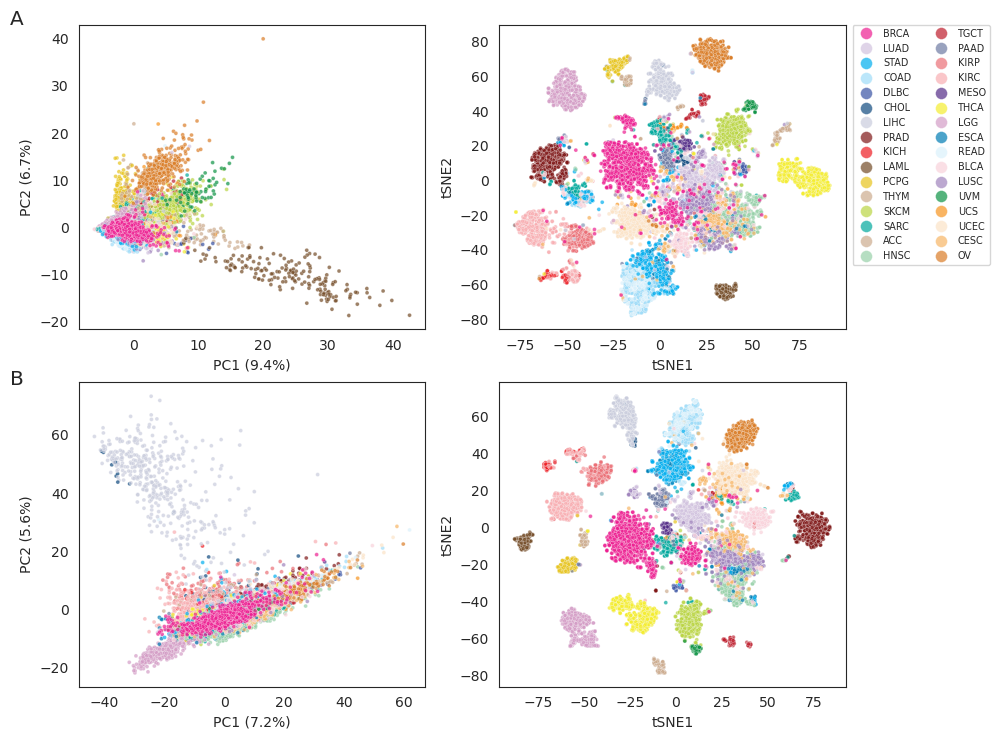

In [53]:
def plot_pca_tsne(df, n, palette, title="mRNA", figsize=(24, 8), perplexity="default", savedir="plots", filename=None, legend=True, axes=None):
    # Extract the expression data (excluding the last four columns)
    expression_data = df.iloc[:, :-4]
    
    variances = expression_data.var(axis=0)
    top_gene = variances.nlargest(n).index
    expression_data = expression_data[top_gene]
    
    # Standardize the expression data
    scaler = StandardScaler()
    expression_data = scaler.fit_transform(expression_data)
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(expression_data)
    
    # Create a new dataframe with the PCA components and cancer types
    pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
    pca_df['sample_type'] = df['sample_type'].values
    pca_df['tissue_type'] = df['tissue_type'].values
    pca_df['cancer_type'] = df['cancer_type'].values
    
    # Determine tSNE perplexity
    if perplexity == "optimal":
        # Find the optimal perplexity
        perplexity_values = np.arange(5, 55, 5)
        divergences = []
    
        for perplexity in perplexity_values:
            model = TSNE(n_components=2, init="pca", perplexity=perplexity)
            model.fit(expression_data)
            divergences.append(model.kl_divergence_)
    
        perplexity = perplexity_values[np.argmin(divergences)]
        
    # Perform tSNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity if perplexity != "default" else 30)
    X_tsne = tsne.fit_transform(expression_data)
    
    # Create a new dataframe with the tSNE components and cancer types
    tsne_df = pd.DataFrame(data=X_tsne, columns=['tSNE1', 'tSNE2'])
    tsne_df['sample_type'] = df['sample_type'].values
    tsne_df['tissue_type'] = df['tissue_type'].values
    tsne_df['cancer_type'] = df['cancer_type'].values
    
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # PCA plot
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cancer_type', palette=palette, alpha=0.7, ax=axes[0], s=8)
    axes[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    axes[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    axes[0].legend().set_visible(False)
    
    # tSNE plot
    sns.scatterplot(data=tsne_df, x='tSNE1', y='tSNE2', hue='cancer_type', palette=palette, alpha=0.7, ax=axes[1], s=8)
    axes[1].set_xlabel('tSNE1')
    axes[1].set_ylabel('tSNE2')
    if legend:
        axes[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, ncol=2, fontsize='x-small', markerscale=3)
    else:
        axes[1].legend().set_visible(False)
        
    if axes is None:
        plt.suptitle(f'PCA and tSNE of highly variable {title}', fontsize=12)
        plt.tight_layout()
        if filename is not None:
            plt.savefig(os.path.join(savedir, filename), bbox_inches='tight')
        plt.show()

def combine_plots(df1, df2, n1, n2, palette, title1='miRNAs (TPMs)', title2='genes (RPKMs)', figsize=(18, 8), savedir="plots", filename=None):
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Plot the first dataset
    plot_pca_tsne(df1, n1, palette, title=title1, axes=axes[0])
    
    # Plot the second dataset
    plot_pca_tsne(df2, n2, palette, title=title2, axes=axes[1], legend=False)
    
    # plt.suptitle('Combined PCA and tSNE Plots', fontsize=16)
    plt.figtext(0.005, 0.9, 'A', fontsize='x-large')
    plt.figtext(0.005, 0.45, 'B', fontsize='x-large')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight', dpi=300)
    plt.show()

# Example usage
combine_plots(mirna_tpm, mrna_rpkm, 200, 2000, palette, figsize=(10, 8), filename='combined_plot.jpeg')

# Combine Count Data and Annotation

## Load Data

In [42]:
TCGA_path = "/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/data/TCGA_isoforms"
TCGA_counts_path = "/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/data/TCGA_counts"

In [43]:
# Isoforms data
mrna_counts = pd.read_csv(os.path.join(TCGA_path, "TCGA_mrna_counts_iso_match.tsv"), sep="\t")
mrna_scaled = pd.read_csv(os.path.join(TCGA_path, "TCGA_mrna_scaled_iso_match.tsv"), sep="\t")
mrna_rpkm = pd.read_csv(os.path.join(TCGA_counts_path, "TCGA_mrna_RPKMs_match.tsv"), sep="\t")
sample_anno_iso = pd.read_csv(os.path.join(TCGA_path, "TCGA_sample_anno_iso_match.tsv"), sep="\t")

mirna_counts = pd.read_csv(os.path.join(TCGA_path, "TCGA_mirna_counts_iso_match.tsv"), sep="\t")
mirna_tpm = pd.read_csv(os.path.join(TCGA_path, "TCGA_mirna_TPMs_iso_match.tsv"), sep="\t")
mirna_anno_iso = pd.read_csv(os.path.join(TCGA_path, "TCGA_mirna_anno_iso_match.tsv"), sep="\t")


In [44]:
sample_anno_iso.set_index('sample_id', inplace=True)

## mRNA

In [45]:
mrna_raw_t = mrna_counts.T
mrna_raw = pd.merge(mrna_raw_t, sample_anno_iso[['tissue_type', 'sample_type', 'color', 'cancer_type']], left_index=True, right_index=True)

In [46]:
mrna_scaled_t = mrna_scaled.T
mrna_scaled = pd.merge(mrna_scaled_t, sample_anno_iso[['tissue_type', 'sample_type', 'color', 'cancer_type']], left_index=True, right_index=True)

In [47]:
mrna_rpkm_t = mrna_rpkm.T
mrna_rpkm = pd.merge(mrna_rpkm_t, sample_anno_iso[['tissue_type', 'sample_type', 'color', 'cancer_type']], left_index=True, right_index=True)

### Save mRNA

In [48]:
save = False
if save:
    mrna_raw.to_csv("miDGD/data/TCGA_mrna_counts_match_iso.tsv", sep='\t')

## miRNA

In [49]:
mirna_counts_t = mirna_counts.T
mirna_raw = pd.merge(mirna_counts_t, sample_anno_iso[['tissue_type', 'sample_type', 'color', 'cancer_type']], left_index=True, right_index=True)

In [50]:
mirna_tpms_t = mirna_tpm.T
mirna_tpm = pd.merge(mirna_tpms_t, sample_anno_iso[['tissue_type', 'sample_type', 'color', 'cancer_type']], left_index=True, right_index=True)

### Save miRNA

In [51]:
save = False
if save:
    mirna_raw.to_csv("miDGD/data/TCGA_mirna_counts_match_iso.tsv", sep='\t')

# Load Data

In [16]:
import pandas as pd

tcga_mrna_iso = pd.read_table("miDGD/data/TCGA_mrna_counts_match_iso.tsv", sep='\t', index_col=[0])
tcga_mirna_iso = pd.read_table("miDGD/data/TCGA_mirna_counts_match_iso.tsv", sep='\t', index_col=[0])
sample_anno_iso = pd.read_table("data/TCGA_isoforms/TCGA_sample_anno_iso_match.tsv", sep='\t', index_col=[0])

In [17]:
print(tcga_mrna_iso.shape)
print(tcga_mirna_iso.shape)
print(sample_anno_iso.shape)

(10676, 19788)
(10676, 2454)
(10676, 14)


In [18]:
sample_anno_iso['sample_type'].groupby(sample_anno_iso['sample_type']).count()

sample_type
Additional - New Primary                             10
Additional Metastatic                                 1
Metastatic                                          378
Primary Blood Derived Cancer - Peripheral Blood     173
Primary Tumor                                      9458
Recurrent Tumor                                      37
Solid Tissue Normal                                 619
Name: sample_type, dtype: int64

# Color palette

In [11]:
palette = dict(zip(sample_anno_iso['cancer_type'], sample_anno_iso['color']))

# PCA

## mRNA

### Raw

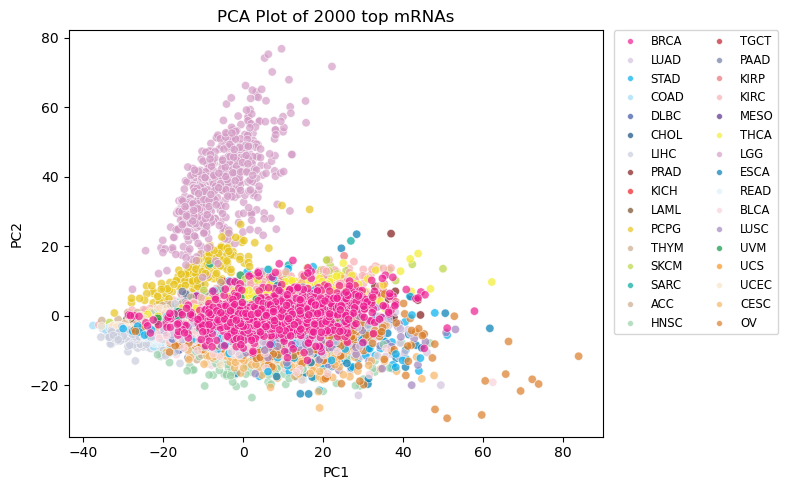

In [23]:
plot_pca(mrna_raw, 2000, palette, title='mRNAs', figsize=(8, 5))

### Scaled

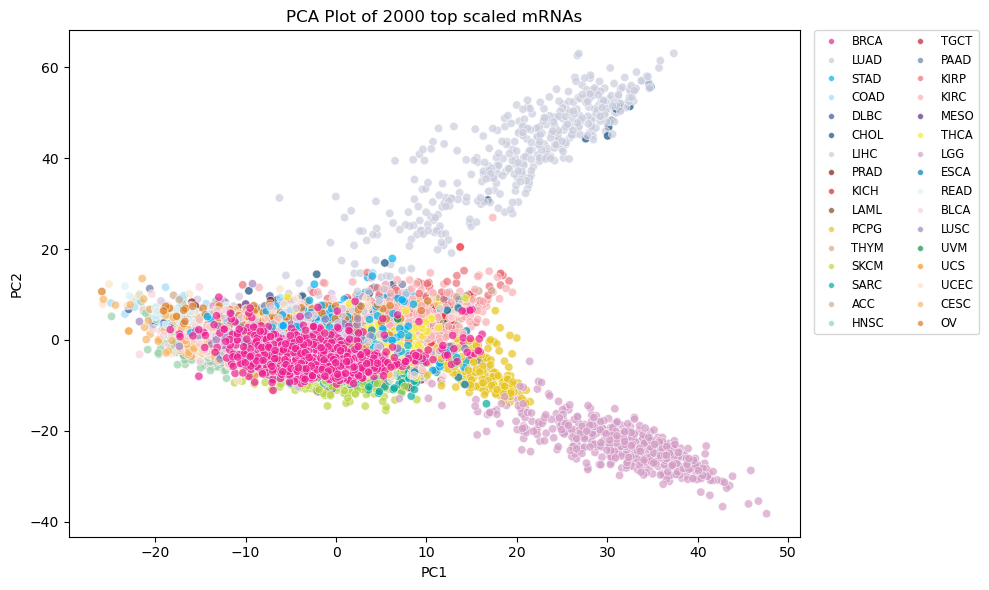

In [19]:
plot_pca(mrna_scaled, 2000, palette, title='scaled mRNAs', figsize=(10, 6))

### RPKM

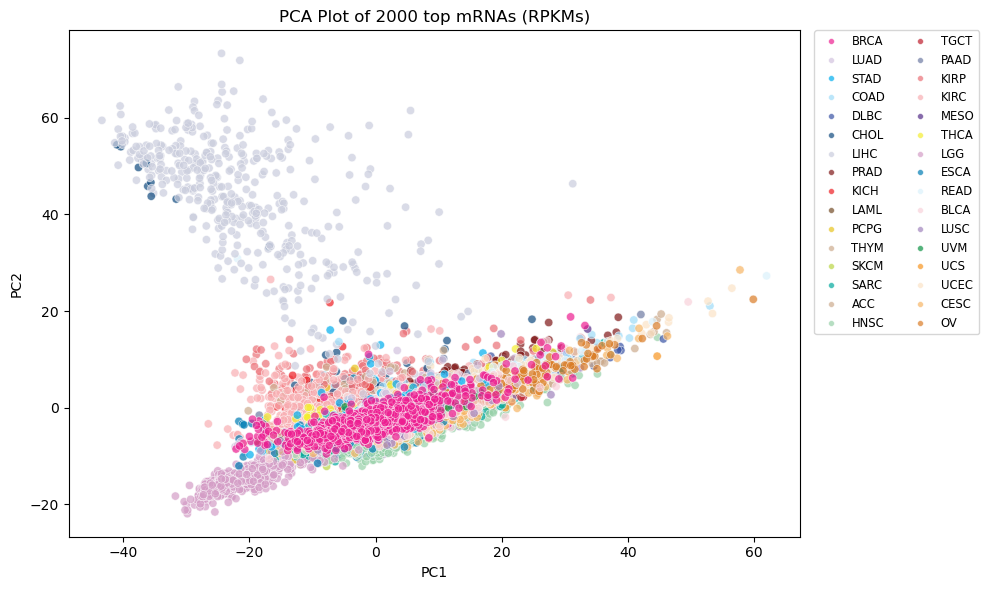

In [33]:
plot_pca(mrna_rpkm, 2000, palette=palette, title='mRNAs (RPKMs)', figsize=(10, 6))

## miRNA

### Raw

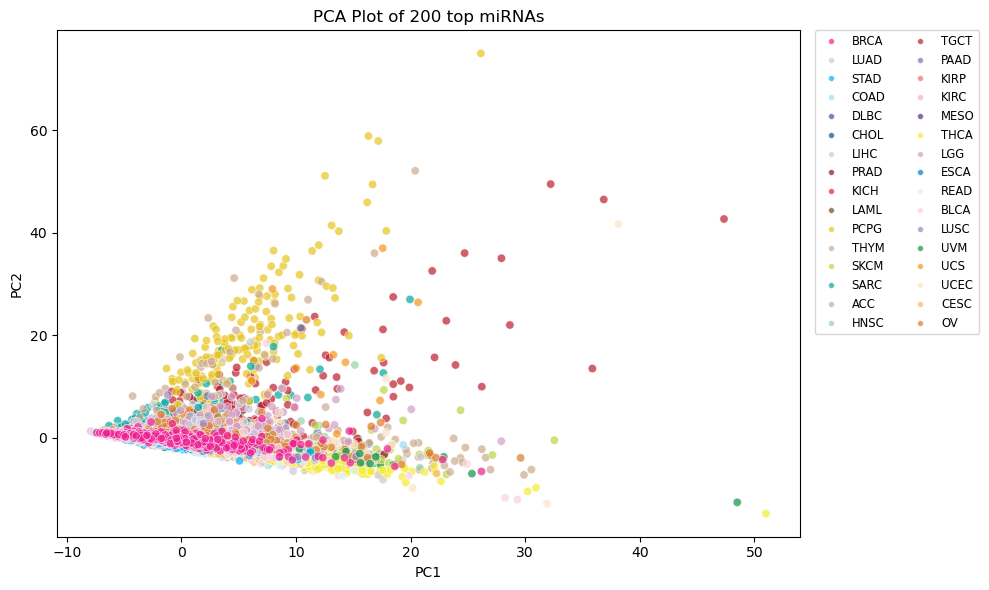

In [21]:
plot_pca(mirna_raw, 200, palette, title='miRNAs', figsize=(10, 6))

### TPM

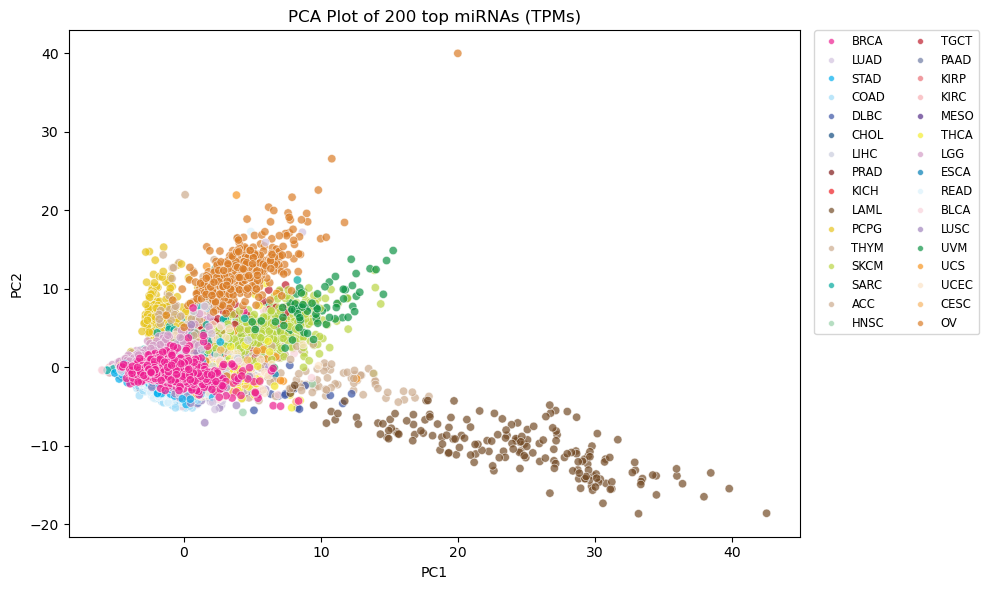

In [22]:
plot_pca(mirna_tpm, 200, palette, title='miRNAs (TPMs)', figsize=(10, 6))

# Hierarchical Clustering

/home/farzamani/mambaforge/envs/midgd-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/farzamani/mambaforge/envs/midgd-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1000x600 with 0 Axes>

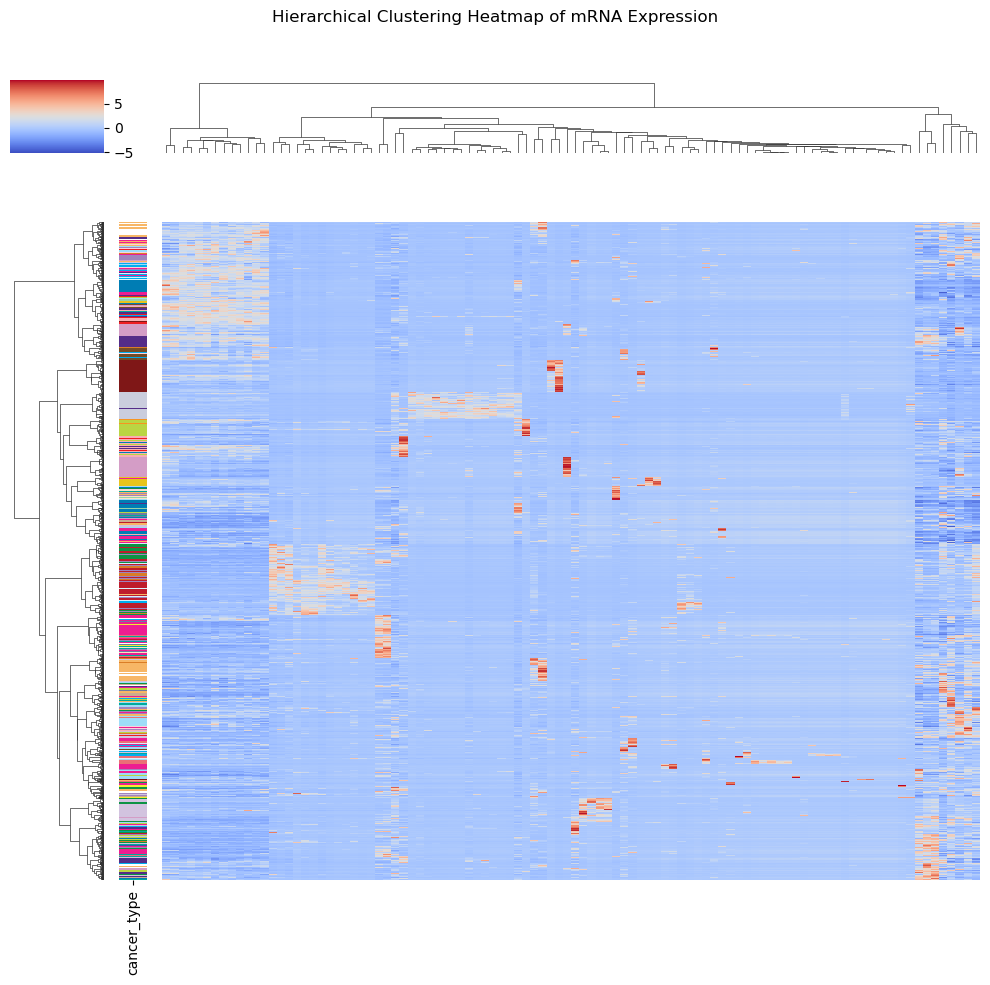

In [23]:
cluster_map(mrna_rpkm, 100, title='Hierarchical Clustering Heatmap of mRNA Expression', figsize=(10, 6))

/home/farzamani/mambaforge/envs/midgd-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/farzamani/mambaforge/envs/midgd-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1000x600 with 0 Axes>

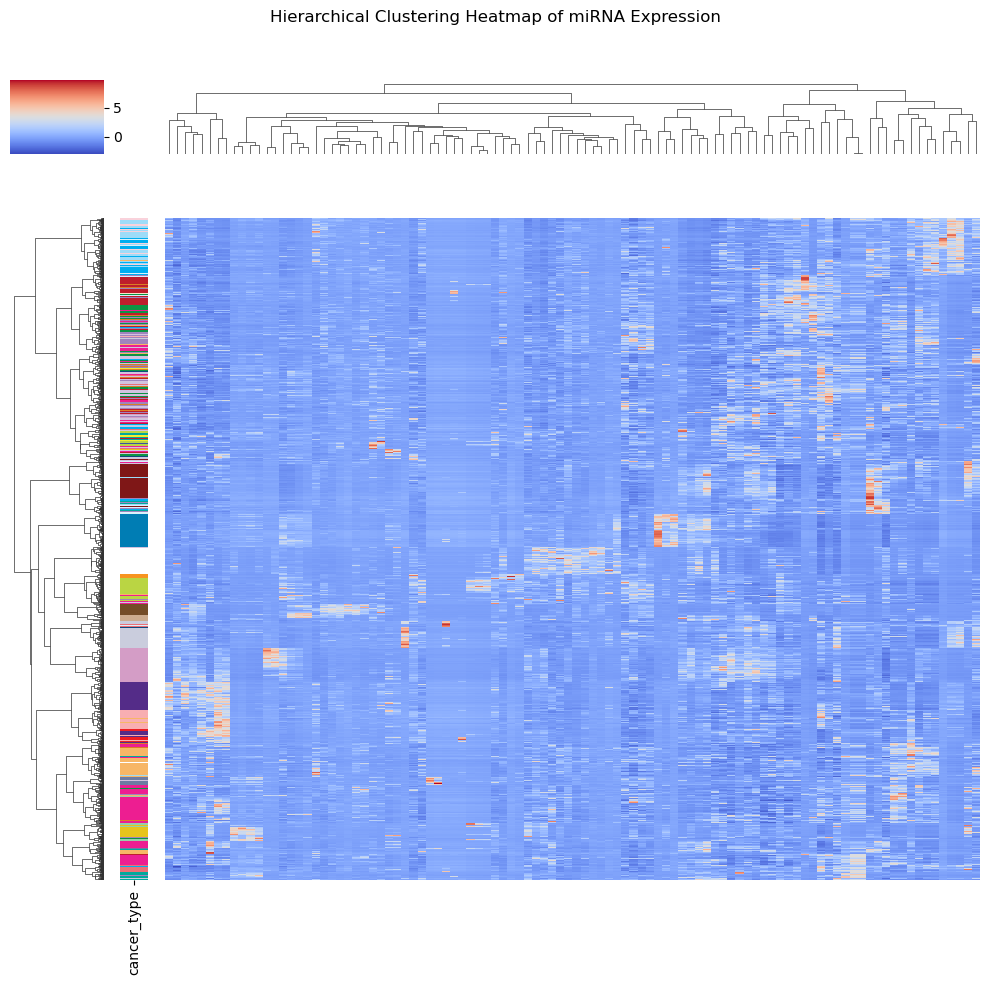

In [24]:
cluster_map(mirna_tpm, 100, title='Hierarchical Clustering Heatmap of miRNA Expression', figsize=(10, 6))

# t-SNE

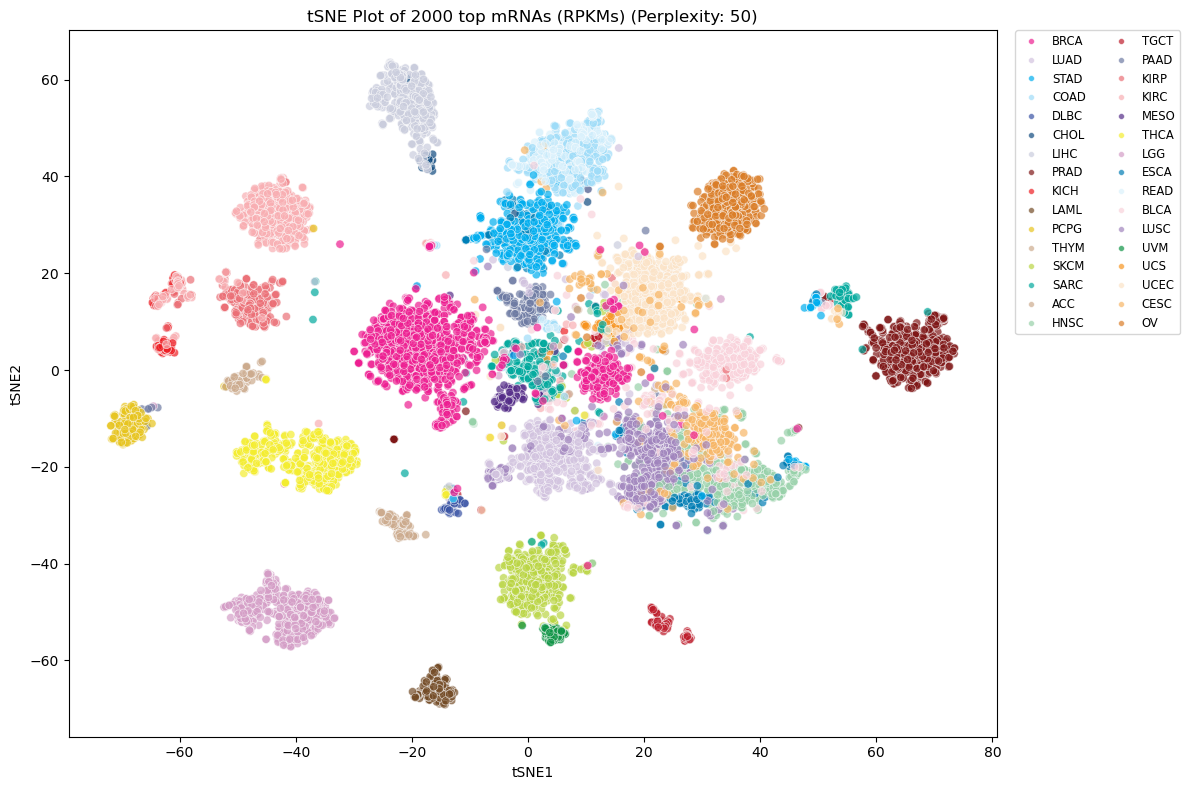

In [25]:
plot_tsne(mrna_rpkm, 2000, palette, title='mRNAs (RPKMs)', perplexity=50)

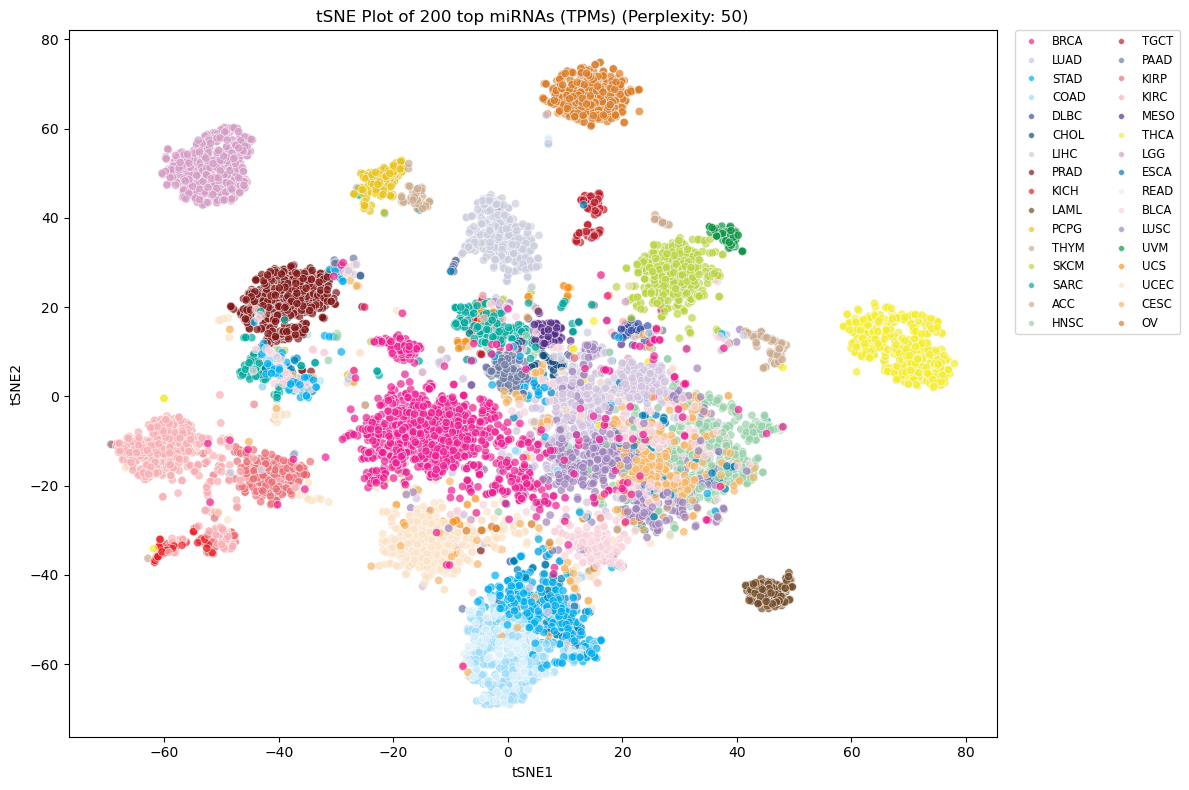

In [26]:
plot_tsne(mirna_tpm, 200, palette, title='miRNAs (TPMs)', perplexity=50)

# Combined

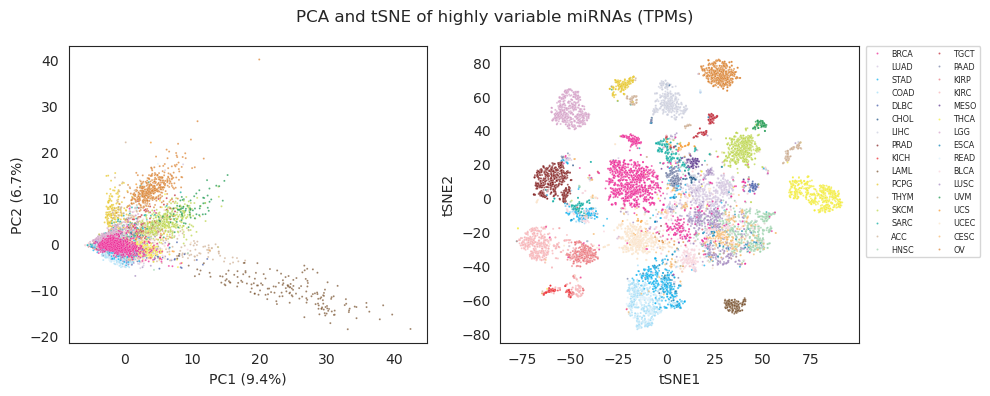

In [128]:
plot_pca_tsne(mirna_tpm, 200, palette, title='miRNAs (TPMs)', figsize=(10, 4), filename='PCA tSNE miRNAs.svg')

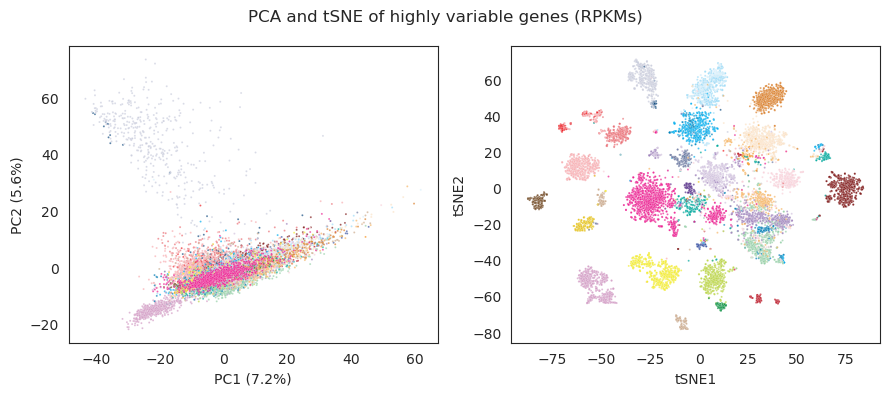

In [130]:
plot_pca_tsne(mrna_rpkm, 2000, palette, title='genes (RPKMs)', figsize=(9, 4), filename='PCA tSNE genes.svg', legend=False)

# Explore data

In [27]:
sample_anno_iso[sample_anno_iso['cancer_type'] == 'LIHC']['sample_type'].groupby(sample_anno_iso['sample_type']).count()

sample_type
Primary Tumor          367
Recurrent Tumor          3
Solid Tissue Normal     50
Name: sample_type, dtype: int64

In [28]:
sample_anno_iso['sample_type'].groupby(sample_anno_iso['sample_type']).count()

sample_type
Additional - New Primary                             10
Additional Metastatic                                 1
Metastatic                                          378
Primary Blood Derived Cancer - Peripheral Blood     173
Primary Tumor                                      9458
Recurrent Tumor                                      37
Solid Tissue Normal                                 619
Name: sample_type, dtype: int64

In [29]:
sample_anno_iso['tissue_type'].groupby(sample_anno_iso['tissue_type']).count()

tissue_type
Normal      619
Tumor     10057
Name: tissue_type, dtype: int64

In [30]:
sample_anno_iso['cancer_type'].groupby(sample_anno_iso['cancer_type']).count()

cancer_type
ACC       79
BLCA     422
BRCA    1179
CESC     309
CHOL      45
COAD     444
DLBC      47
ESCA     197
HNSC     543
KICH      91
KIRC     568
KIRP     323
LAML     173
LGG      527
LIHC     420
LUAD     525
LUSC     513
MESO      87
OV       426
PAAD     183
PCPG     187
PRAD     546
READ     163
SARC     261
SKCM     451
STAD     445
TGCT     139
THCA     571
THYM     122
UCEC     553
UCS       57
UVM       80
Name: cancer_type, dtype: int64

In [31]:
len(sample_anno_iso['cancer_type'].unique())

32

## miR-122

- hsa-miR-122-5p	MIMAT0000421					
- hsa-miR-122-3p	MIMAT0004590					
- hsa-miR-122b-5p	MIMAT0019876					
- hsa-miR-122b-3p	MIMAT0019877	

In [32]:
tcga_mirna_raw.filter(regex='mir-122').columns.tolist()

NameError: name 'tcga_mirna_raw' is not defined

In [ ]:
mir_122 = ["MIMAT0000421", "MIMAT0004590", "MIMAT0019876", "MIMAT0019877"]

def plot_loghist(x, bins=10):
  hist, bins = np.histogram(x+1, bins)
  logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
  plt.hist(x, bins=logbins)
  plt.xscale('log')

plot_loghist(tcga_mirna_iso["MIMAT0019877"])

In [ ]:
mir_122, mir_122_5p, mir_122_3p, mir_122b_5p, mir_122b_3p = tcga_mirna_raw['hsa-mir-122'], tcga_mirna_iso["MIMAT0000421"], tcga_mirna_iso["MIMAT0004590"], tcga_mirna_iso["MIMAT0019876"], tcga_mirna_iso["MIMAT0019877"]
df_corr_mir_122 = pd.concat([mir_122, 
                     mir_122_5p,
                     mir_122_3p], 
                     axis=1).dropna()

df_corr_mir_122.columns = ['mir_122', 'mir_122_5p', 'mir_122_3p']
df_corr_mir_122.corr()

## let-7a

In [ ]:
tcga_mirna_raw.filter(regex='let-7').columns.tolist()

In [ ]:
let_7a_1, let_7a_2, let_7a_3, let_7a_5p, let_7a_3p = tcga_mirna_raw['hsa-let-7a-1'], tcga_mirna_raw['hsa-let-7a-2'], tcga_mirna_raw['hsa-let-7a-2'], tcga_mirna_iso["MIMAT0000062"], tcga_mirna_iso["MIMAT0004481"]
df_corr_let_7a = pd.concat([let_7a_1, 
                     let_7a_2,
                     let_7a_3,
                     let_7a_5p,
                     let_7a_3p], 
                     axis=1).dropna()

df_corr_let_7a.columns = ['let_7a_1', 'let_7a_2', 'let_7a_3', 'let_7a_5p', 'let_7a_3p']
df_corr_let_7a.corr()

# Tissue Specific miRNAs

In [ ]:
sample_anno_iso[['cancer_type', 'primary_site', 'cancer_name']].drop_duplicates().dropna()

- MIMAT0000421: hsa-miR-122-5p --> Liver
- MIMAT0000422: hsa-miR-124-3p --> Brain
- MIMAT0000435: hsa-miR-143-3p --> Bladder
- MIMAT0000067: hsa-let-7f-5p
- MIMAT0001631: hsa-miR-451a
- MIMAT0000427: hsa-miR-133a-3p --> Muscle
- MIMAT0000728: hsa-miR-375-3p --> Pancreas ?

In [ ]:
[[a, mirna_tpms_merged[['MIMAT0000421']][mirna_tpms_merged['cancer_type'] == a].mean()] for a in mirna_tpms_merged['cancer_type'].unique()]

# Calculate Tau

In [ ]:
import pandas as pd

# Assuming tcga_mirna_iso is your DataFrame with the last column being the tissue annotation
# Separate the tissue annotations from the expression data
tissue_annotations = mirna_tpms_merged.iloc[:, -1]
expression_data = mirna_tpms_merged.iloc[:, :-4]

# Group the data by tissue and calculate the mean expression for each miRNA in each tissue
grouped_data = expression_data.groupby(tissue_annotations).mean()

# Calculate the Tau tissue-specificity index (TSI) for each miRNA
tsi_scores = {}
for mirna in grouped_data.columns:
    max_expression = grouped_data[mirna].max()
    total_expression = grouped_data[mirna].sum()
    tsi = max_expression / total_expression
    tsi_scores[mirna] = tsi

# Convert the TSI scores to a DataFrame
tsi_df = pd.DataFrame.from_dict(tsi_scores, orient='index', columns=['TSI'])

# Sort the DataFrame based on TSI scores in descending order
tsi_df = tsi_df.sort_values(by='TSI', ascending=False)

# Optionally, set a threshold for tissue specificity and filter miRNAs
threshold = 0.8  # This is an example threshold, adjust based on your criteria
tissue_specific_mirnas = tsi_df[tsi_df['TSI'] > threshold]

# Output the tissue-specific miRNAs
print("Tissue-specific miRNAs based on TSI > {}:".format(threshold))
print(tissue_specific_mirnas)


In [ ]:
import pandas as pd

# Assuming tcga_mirna_iso is your DataFrame with the last column being the tissue annotation
# Separate the tissue annotations from the expression data
tissue_annotations = mirna_tpms_merged.iloc[:, -1]
expression_data = mirna_tpms_merged.iloc[:, :-4]

# Group the data by tissue and calculate the mean expression for each miRNA in each tissue
grouped_data = expression_data.groupby(tissue_annotations).mean()

# Calculate the Tau tissue-specificity index (TSI) for each miRNA and identify the tissue type
results = []
for mirna in grouped_data.columns:
    max_expression = grouped_data[mirna].max()
    total_expression = grouped_data[mirna].sum()
    tsi = max_expression / total_expression
    tissue_type = grouped_data[mirna].idxmax()  # Get the tissue type with the maximum expression
    results.append({'miRNA': mirna, 'TSI': tsi, 'Tissue_Type': tissue_type})

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Sort the DataFrame based on TSI scores in descending order
results_df = results_df.sort_values(by='TSI', ascending=False)

# Optionally, set a threshold for tissue specificity and filter miRNAs
threshold = 0.7  # This is an example threshold, adjust based on your criteria
tissue_specific_mirnas = results_df[results_df['TSI'] > threshold]

# Output the tissue-specific miRNAs
print("Tissue-specific miRNAs based on TSI > {}:".format(threshold))
print(tissue_specific_mirnas)

In [ ]:
import pandas as pd

# Assuming tcga_mirna_iso is your DataFrame with the last column being the tissue annotation
# Separate the tissue annotations from the expression data
tissue_annotations = mirna_tpms_merged.iloc[:, -1]
expression_data = mirna_tpms_merged.iloc[:, :-4]

# Group the data by tissue and calculate the mean expression for each miRNA in each tissue
grouped_data = expression_data.groupby(tissue_annotations).mean()

# Threshold for tissue specificity
threshold = 0.7

# Calculate the Tau tissue-specificity index (TSI) for each miRNA and identify the tissue type
results = []
for mirna in grouped_data.columns:
    tissue_expression = grouped_data[mirna]
    max_expression = tissue_expression.max()
    mean_expression = tissue_expression.mean()
    total_expression = tissue_expression.sum()
    tsi = max_expression / total_expression
    tissue_type = tissue_expression.idxmax()  # Get the tissue type with the maximum expression
    
    # Check if the maximum expression is significantly higher than in other tissues
    # This can be done by setting a threshold for the minimum expression level
    # For example, the max expression should be at least 2 times higher than the mean of other tissues
    other_tissues_mean = tissue_expression[tissue_expression < max_expression].mean()
    if mean_expression >= 50 * other_tissues_mean and tsi>threshold:
        results.append({'miRNA': mirna, 'TSI': tsi, 'Tissue_Type': tissue_type})

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Sort the DataFrame based on TSI scores in descending order
results_df = results_df.sort_values(by='TSI', ascending=False)

# Output the tissue-specific miRNAs with high expression in their specific tissue
print("Tissue-specific miRNAs with high expression in a specific tissue:")
print(results_df)

In [ ]:
results_df[results_df.miRNA == 'MIMAT0000421']

# Samples

In [13]:
savedir = 'plots'

In [14]:
sample_anno_iso.head(3)

,cancer_type,sample_submitter_id,cancer_name,primary_site,sample_type,id_match,tissue_type,tumor_descriptor,age_at_index,gender,vital_status,tissue_or_organ_of_origin,color
sample_id,,,,,,,,,,,,,
TCGA-EW-A6SA-01A-21R-A32P-07,BRCA,TCGA-EW-A6SA-01A,Breast Invasive Carcinoma,Breast,Primary Tumor,e19e25fc-d85f-4caa-a22d-d48a461a735d,Tumor,Primary,59,male,Alive,"Breast, NOS",#ED1E91
TCGA-E2-A14W-01A-11R-A12D-07,BRCA,TCGA-E2-A14W-01A,Breast Invasive Carcinoma,Breast,Primary Tumor,4a010aac-f287-4fa7-9d3b-8af64c5d23e4,Tumor,Primary,78,male,Alive,"Breast, NOS",#ED1E91
TCGA-EW-A1PD-01A-11R-A144-07,BRCA,TCGA-EW-A1PD-01A,Breast Invasive Carcinoma,Breast,Primary Tumor,010de2d6-ab41-4779-923a-1c288296e267,Tumor,Primary,61,male,Alive,"Breast, NOS",#ED1E91


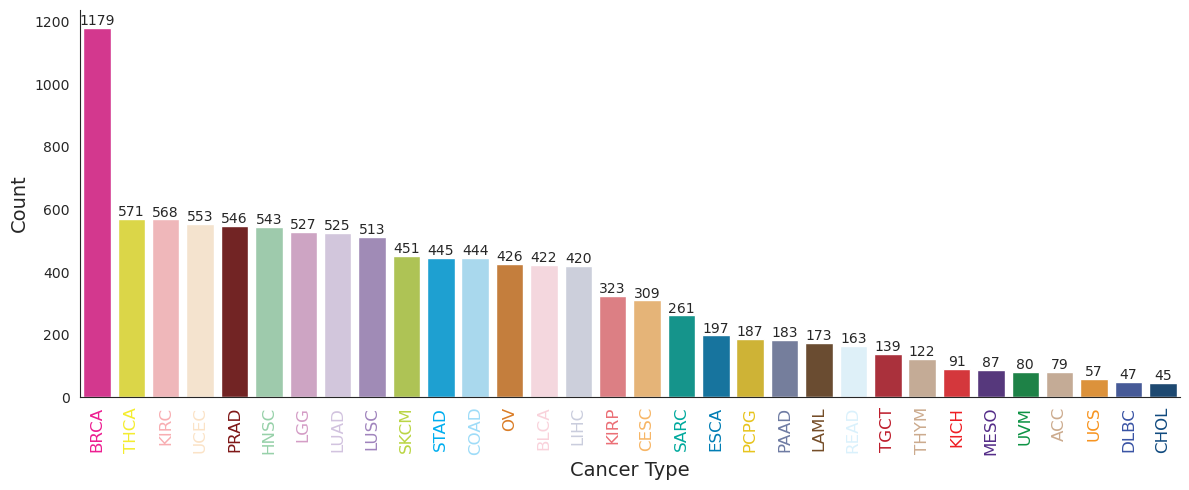

In [27]:
sns.set_style(style="white")
color_mapping = dict(zip(sample_anno_iso['cancer_type'], sample_anno_iso['color']))

cancer_type_counts = sample_anno_iso['cancer_type'].value_counts().reset_index()
cancer_type_counts.columns = ['cancer_type', 'count']

# Create a bar plot
plt.figure(figsize=(12, 5))
barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=cancer_type_counts, palette=color_mapping)
plt.xlabel('Cancer Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
# plt.title('Number of Samples by Cancer Type', fontsize=18)
plt.xticks(rotation=90, fontsize=12)  # Rotate the x labels to show them more clearly
plt.yticks(fontsize=10)

for ax in plt.gcf().axes:
    labels = ax.get_xticklabels()
    for label, cancer_type in zip(labels, cancer_type_counts['cancer_type'].unique()):
        label.set_color(palette[cancer_type])

# Annotate each bar with the count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                     ha='center', va='center',  # Center the text horizontally and vertically
                     xytext=(0, 5),  # Offset the text by 10 points vertically
                     textcoords='offset points')  # Use offset points for the text coordinates

plt.tight_layout()  # Adjust the layout to fit the x labels
sns.despine()
plt.savefig(os.path.join(savedir, 'Number of samples by cancer type.svg'), bbox_inches='tight')
plt.show()

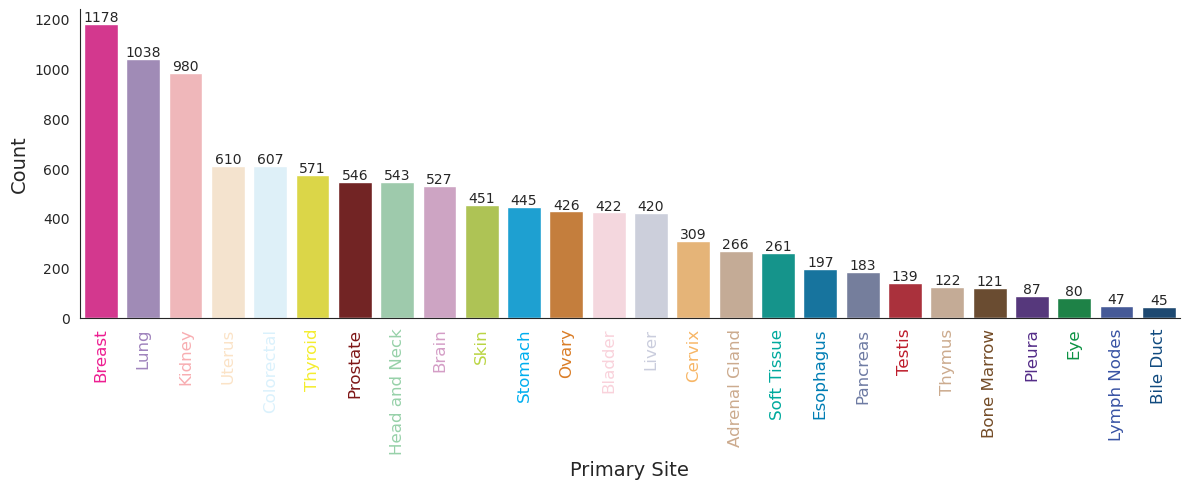

In [16]:
sns.set_style(style="white")
color_mapping = dict(zip(sample_anno_iso['primary_site'], sample_anno_iso['color']))

primary_site_counts = sample_anno_iso['primary_site'].value_counts().reset_index()
primary_site_counts.columns = ['primary_site', 'count']

# Create a bar plot
plt.figure(figsize=(12, 5))
barplot = sns.barplot(x='primary_site', hue='primary_site', y='count', data=primary_site_counts, palette=color_mapping)
plt.xlabel('Primary Site', fontsize=14)
plt.ylabel('Count', fontsize=14)
# plt.title('Number of Samples by Primary Site', fontsize=18)
plt.xticks(rotation=90, fontsize=12)  # Rotate the x labels to show them more clearly
plt.yticks(fontsize=10)

for ax in plt.gcf().axes:
    labels = ax.get_xticklabels()
    for label, cancer_type in zip(labels, primary_site_counts['primary_site'].unique()):
        label.set_color(color_mapping[cancer_type])

# Annotate each bar with the count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                     ha='center', va='center',  # Center the text horizontally and vertically
                     xytext=(0, 5),  # Offset the text by 10 points vertically
                     textcoords='offset points')  # Use offset points for the text coordinates

plt.tight_layout()  # Adjust the layout to fit the x labels
sns.despine()
plt.savefig(os.path.join(savedir, 'Number of samples by primary site.svg'), bbox_inches='tight')
plt.show()

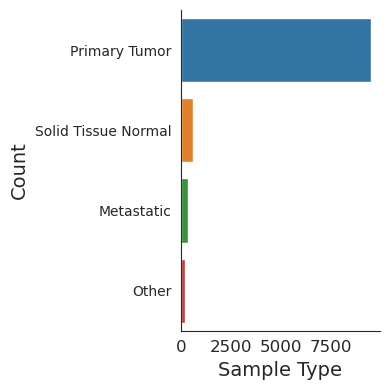

In [17]:
sns.set_style(style="white")
# color_mapping = dict(zip(sample_anno_iso['sample_type'], sample_anno_iso['color']))
sample_anno_iso_copy = sample_anno_iso

# Define the categories to be grouped into "Other"
other_categories = [
    'Primary Blood Derived Cancer - Peripheral Blood', 
    'Recurrent Tumor', 
    'Additional - New Primary', 
    'Additional Metastatic'
]

# Replace these categories with "Other"
sample_anno_iso_copy['sample_type'] = sample_anno_iso_copy['sample_type'].replace(other_categories, 'Other')

sample_type_counts = sample_anno_iso_copy['sample_type'].value_counts().reset_index()
sample_type_counts.columns = ['sample_type', 'count']

# Create a bar plot
plt.figure(figsize=(4, 4))
barplot = sns.barplot(y='sample_type', x='count', hue='sample_type', data=sample_type_counts)
plt.xlabel('Sample Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
# plt.title('Number of Samples by Sample Type', fontsize=18)
plt.xticks(rotation=0, fontsize=12)  # Rotate the x labels to show them more clearly
plt.yticks(fontsize=10)

plt.tight_layout()  # Adjust the layout to fit the x labels
sns.despine()
plt.savefig(os.path.join(savedir, 'Number of samples by sample type.svg'), bbox_inches='tight')
plt.show()

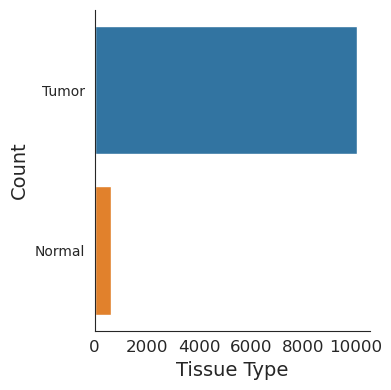

In [19]:
sns.set_style(style="white")

tissue_type_counts = sample_anno_iso['tissue_type'].value_counts().reset_index()
tissue_type_counts.columns = ['tissue_type', 'count']

# Create a bar plot
plt.figure(figsize=(4, 4))
barplot = sns.barplot(y='tissue_type', x='count', hue='tissue_type', data=tissue_type_counts)
plt.xlabel('Tissue Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
# plt.title('Number of Samples by Sample Type', fontsize=18)
plt.xticks(rotation=0, fontsize=12)  # Rotate the x labels to show them more clearly
plt.yticks(fontsize=10)

plt.tight_layout()  # Adjust the layout to fit the x labels
sns.despine()
plt.savefig(os.path.join(savedir, 'Number of samples by tissue type.svg'), bbox_inches='tight')
plt.show()

In [21]:
sample_anno_iso['sample_type'].value_counts().reset_index()

,sample_type,count
0,Primary Tumor,9458
1,Solid Tissue Normal,619
2,Metastatic,378
3,Other,221


In [20]:
tissue_type_counts

,tissue_type,count
0,Tumor,10057
1,Normal,619


In [23]:
primary_site_counts

,primary_site,count
0,Breast,1178
1,Lung,1038
2,Kidney,980
3,Uterus,610
4,Colorectal,607
5,Thyroid,571
6,Prostate,546
7,Head and Neck,543
8,Brain,527
9,Skin,451
